In [2]:
import os
os.chdir('/net/hcihome/storage/sdubey/AML')

In [5]:
import coeff_functs as fu
import coupling_layers as la
import reshapes as re
import fixed_transforms as fm

#import MNIST_dataLoader as dl
from time import time

from tqdm import tqdm
import torch
import torch.nn
import torch.optim
import numpy as np


import torch

In [127]:
#load MNIST_dataLoader.py


import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms



def load_mnist(aug=True):
    """
    Load and save MNIST data and download if not already downloaded.
    Applied transformations: RandomResizedCrop(),
    RandomVerticalFlip(), RandomHorizontalFlip(), RandomRotation(), ToTensor().
    :return: trainset, testset, classes of MNIST
    """
    augm_sigma = 0.08

    save_path = './mnist_data/'

    transform_train = transforms.Compose([transforms.RandomRotation(20), transforms.ColorJitter(),  transforms.ToTensor()])  

    transform_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                         lambda x: x + augm_sigma * torch.randn_like(x)])

    transform = transforms.Compose([transforms.ToTensor()])

    trainset = datasets.MNIST(root=save_path, train=True, transform=transform_norm, download=True)
    testset = datasets.MNIST(root=save_path, train=False, transform=transform, download=True)

    classes = [x for x in range(10)]

    return trainset, testset, classes


def make_dataloaders(trainset, testset, batch_size, valid_size=0):
    """
    Create loaders for the train-, validation- and testset.
    :param trainset: trainset for which a train loader and valication loader will be created
    :param testset: testset for which we want to create a test loader
    :param batch_size: size of the batch the loader will load during training
    :param valid_size: size of the dataset wrapped by the validation loader, should be more than batch_size.
    :return: trainloader, validloader, testloader
    """
    batch_size = batch_size
    data_mean = 0.128
    data_std = 0.305
    
    # amplitude for the noise augmentation
    augm_sigma = 0.08

    indices = torch.randperm(len(trainset))
    #print(indices)
    train_idx = indices[:len(indices) - valid_size]
    valid_idx = indices[len(indices) - valid_size:]
    
    

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx),
                                                  )

    validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx),
                                                  )

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                 drop_last=True)

    return trainloader, validloader, testloader



In [11]:
trainset, testset, classes = load_mnist()
trainloader, validloader, testloader = make_dataloaders(trainset, testset, batch_size = 256)

tensor([55253,  5469, 50584,  ..., 56811, 24244, 23991])


In [12]:
''''The framework module contains the logic used in building the graph and
inferring the order that the nodes have to be executed in forward and backward
direction.'''

import sys
import warnings
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

import dummy_modules as dummys


class Node:
    '''The Node class represents one transformation in the graph, with an
    arbitrary number of in- and outputs.'''
    def __init__(self, inputs, module_type, module_args, conditions=[], name=None):
        if name:
            self.name = name
        else:
            self.name = hex(id(self))[-6:]
        for i in range(256):
            exec('self.out{0} = (self, {0})'.format(i))

        self.inputs = self.parse_inputs(inputs)
        if isinstance(conditions, (list, tuple)):
            self.conditions = conditions
        else:
            self.conditions = [conditions,]

        self.outputs = []
        self.module_type = module_type
        self.module_args = module_args

        self.input_dims = None
        self.module = None
        self.computed = None
        self.computed_rev = None
        self.id = None

    def parse_inputs(self, inputs):
        if isinstance(inputs, (list, tuple)):
            if isinstance(inputs[0], (list, tuple)):
                return inputs
            elif len(inputs) == 2:
                return [inputs,]
            else:
                raise RuntimeError(f"Cannot parse inputs provided to node '{self.name}'.")
        else:
            assert isinstance(inputs, Node), "Received object of invalid type "                f"({type(inputs)}) as input for node '{name}'."
            return [(inputs, 0),]

    def build_modules(self, verbose=True):
        ''' Returns a list with the dimension of each output of this node,
        recursively calling build_modules of the nodes connected to the input.
        Use this information to initialize the pytorch nn.Module of this node.
        '''

        if not self.input_dims:  # Only do it if this hasn't been computed yet
            self.input_dims = [n.build_modules(verbose=verbose)[c]
                               for n, c in self.inputs]
            try:
                if len(self.conditions) > 0:
                    c_dims = [c.build_modules(verbose=verbose)[0] for c in self.conditions]
                    self.module = self.module_type(self.input_dims, dims_c=c_dims,
                                                   **self.module_args)
                else:
                    self.module = self.module_type(self.input_dims,
                                                   **self.module_args)
            except Exception as e:
                print('Error in node %s' % (self.name))
                raise e

            if verbose:
                print(f"Node '{self.name}' takes the following inputs:")
                for d, (n, c) in zip(self.input_dims, self.inputs):
                    print(f"\t Output #{c} of node '{n.name}' with dims {d}")
                for c in self.conditions:
                    print(f"\t conditioned on node '{c.name}' " +
                          f"with dims {c.data.shape}")
                print()

            self.output_dims = self.module.output_dims(self.input_dims)
            self.n_outputs = len(self.output_dims)

        return self.output_dims

    def run_forward(self, op_list):
        '''Determine the order of operations needed to reach this node. Calls
        run_forward of parent nodes recursively. Each operation is appended to
        the global list op_list, in the form (node ID, input variable IDs,
        output variable IDs)'''

        if not self.computed:

            # Compute all nodes which provide inputs, filter out the
            # channels you need
            self.input_vars = []
            for i, (n, c) in enumerate(self.inputs):
                self.input_vars.append(n.run_forward(op_list)[c])
                # Register self as an output in the input node
                n.outputs.append((self, i))
            # Compute all nodes which provide conditioning
            self.condition_vars = []
            for i, c in enumerate(self.conditions):
                self.condition_vars.append(c.run_forward(op_list)[0])
                # Register self as an output in the condition node
                c.outputs.append((self, i))

            # All outputs could now be computed
            self.computed = [(self.id, i) for i in range(self.n_outputs)]
            op_list.append((self.id, self.input_vars, self.computed, self.condition_vars))

        # Return the variables you have computed (this happens mulitple times
        # without recomputing if called repeatedly)
        return self.computed

    def run_backward(self, op_list):
        '''See run_forward, this is the same, only for the reverse computation.
        Need to call run_forward first, otherwise this function will not
        work'''

        assert len(self.outputs) > 0, "Call run_forward first"
        if not self.computed_rev:

            # These are the input variables that must be computed first
            output_vars = [(self.id, i) for i in range(self.n_outputs)]

            # Recursively compute these
            for n, c in self.outputs:
                n.run_backward(op_list)

            # The variables that this node computes are the input variables
            # from the forward pass
            self.computed_rev = self.input_vars
            if len(self.condition_vars) == 0:
                self.condition_vars = [c.run_forward(op_list)[0] for c in self.conditions]
            op_list.append((self.id, output_vars, self.computed_rev, self.condition_vars))

        return self.computed_rev


class InputNode(Node):
    '''Special type of node that represents the input data of the whole net (or
    ouput when running reverse)'''

    def __init__(self, *dims, name='node'):
        self.name = name
        self.data = dummys.dummy_data(*dims)
        self.outputs = []
        self.conditions = []
        self.condition_vars = []
        self.module = None
        self.computed_rev = None
        self.n_outputs = 1
        self.input_vars = []
        self.out0 = (self, 0)

    def build_modules(self, verbose=True):
        return [self.data.shape]

    def run_forward(self, op_list):
        return [(self.id, 0)]


class ConditionNode(Node):
    '''Special type of node that represents contitional input to the internal
    networks inside coupling layers'''

    def __init__(self, *dims, name='node'):
        self.name = name
        self.data = dummys.dummy_data(*dims)
        self.outputs = []
        self.conditions = []
        self.condition_vars = []
        self.module = None
        self.computed_rev = None
        self.n_outputs = 1
        self.input_vars = []
        self.out0 = (self, 0)

    def build_modules(self, verbose=True):
        return [self.data.shape]

    def run_forward(self, op_list):
        return [(self.id, 0)]


class OutputNode(Node):
    '''Special type of node that represents the output of the whole net (of the
    input when running in reverse)'''
    class dummy(nn.Module):

        def __init__(self, *args):
            super(OutputNode.dummy, self).__init__()

        def __call__(*args):
            return args

        def output_dims(*args):
            return args

    def __init__(self, inputs, name='node'):
        self.module_type, self.module_args = self.dummy, {}
        self.output_dims = []
        self.inputs = self.parse_inputs(inputs)
        self.conditions = []
        self.input_dims, self.module = None, None
        self.computed = None
        self.id = None
        self.name = name

        for c, inp in enumerate(self.inputs):
            inp[0].outputs.append((self, c))

    def run_backward(self, op_list):
        return [(self.id, 0)]


class ReversibleGraphNet(nn.Module):
    '''This class represents the invertible net itself. It is a subclass of
    torch.nn.Module and supports the same methods. The forward method has an
    additional option 'rev', whith which the net can be computed in reverse.'''

    def __init__(self, node_list, ind_in=None, ind_out=None, verbose=True):
        '''node_list should be a list of all nodes involved, and ind_in,
        ind_out are the indexes of the special nodes InputNode and OutputNode
        in this list.'''
        super(ReversibleGraphNet, self).__init__()

        # Gather lists of input, output and condition nodes
        if ind_in is not None:
            warnings.warn("Use of 'ind_in' and 'ind_out' for ReversibleGraphNet is deprecated, " +
                          "input and output nodes are detected automatically.")
            if isinstance(ind_in, int):
                self.ind_in = list([ind_in])
            else:
                self.ind_in = ind_in
        else:
            self.ind_in = [i for i in range(len(node_list))
                           if isinstance(node_list[i], InputNode)]
            assert len(self.ind_in) > 0, "No input nodes specified."
        if ind_out is not None:
            warnings.warn("Use of 'ind_in' and 'ind_out' for ReversibleGraphNet is deprecated, " +
                          "input and output nodes are detected automatically.")
            if isinstance(ind_out, int):
                self.ind_out = list([ind_out])
            else:
                self.ind_out = ind_out
        else:
            self.ind_out = [i for i in range(len(node_list))
                            if isinstance(node_list[i], OutputNode)]
            assert len(self.ind_out) > 0, "No output nodes specified."
        self.ind_cond = [i for i in range(len(node_list))
                         if isinstance(node_list[i], ConditionNode)]

        self.return_vars = []
        self.input_vars = []
        self.cond_vars = []

        # Assign each node a unique ID
        self.node_list = node_list
        for i, n in enumerate(node_list):
            n.id = i
            n.graph = self

        # Recursively build the nodes nn.Modules and determine order of
        # operations
        ops = []
        for i in self.ind_out:
            node_list[i].build_modules(verbose=verbose)
            node_list[i].run_forward(ops)

        # create list of Pytorch variables that are used
        variables = set()
        for o in ops:
            variables = variables.union(set(o[1] + o[2] + o[3]))
        self.variables_ind = list(variables)

        self.indexed_ops = self.ops_to_indexed(ops)

        self.module_list = nn.ModuleList([n.module for n in node_list])
        self.module_cond = [(len(n.conditions) > 0) for n in node_list]
        self._buffers = {F'tmp_var_{i}' : None for i in range(len(variables))}

        # Find out the order of operations for reverse calculations
        ops_rev = []
        for i in self.ind_in + self.ind_cond:
            node_list[i].run_backward(ops_rev)
        self.indexed_ops_rev = self.ops_to_indexed(ops_rev)

    def ops_to_indexed(self, ops):
        '''Helper function to translate the list of variables (origin ID, channel),
        to variable IDs.'''
        result = []

        for o in ops:
            try:
                vars_in = [self.variables_ind.index(v) for v in o[1]]
            except ValueError:
                vars_in = -1

            vars_out = [self.variables_ind.index(v) for v in o[2]]
            vars_cond = [self.variables_ind.index(v) for v in o[3]]

            # Collect input/output/conditioning nodes in separate lists, but don't
            # add to indexed ops
            if o[0] in self.ind_out:
                self.return_vars.append(self.variables_ind.index(o[1][0]))
                continue
            if o[0] in self.ind_in:
                self.input_vars.append(self.variables_ind.index(o[1][0]))
                continue
            if o[0] in self.ind_cond:
                if self.variables_ind.index(o[1][0]) not in self.cond_vars:
                    self.cond_vars.append(self.variables_ind.index(o[1][0]))
                else:
                    print('Is this branch ever reached?')
                continue

            result.append((o[0], vars_in, vars_out, vars_cond))

        # Sort input/output/conditioning variables so they correspond to initial
        # node list order
        self.return_vars.sort(key=lambda i: self.variables_ind[i][0])
        self.input_vars.sort(key=lambda i: self.variables_ind[i][0])
        self.cond_vars.sort(key=lambda i: self.variables_ind[i][0])

        return result

    def forward(self, x, c=None, rev=False, intermediate_outputs=False):
        '''Forward or backward computation of the whole net.'''

        if rev:
            use_list = self.indexed_ops_rev
            input_vars, output_vars = self.return_vars, self.input_vars
        else:
            use_list = self.indexed_ops
            input_vars, output_vars = self.input_vars, self.return_vars

        # Assign input data to respective variables
        if isinstance(x, (list, tuple)):
            assert len(x) == len(input_vars), (
                f"Got list of {len(x)} input tensors for "
                f"{'inverse' if rev else 'forward'} pass, but expected "
                f"{len(input_vars)}."
            )
            for i in range(len(input_vars)):
                self._buffers[F'tmp_var_{input_vars[i]}'] = x[i]
        else:
            assert len(input_vars) == 1, (f"Got single input tensor for "
                                          f"{'inverse' if rev else 'forward'} "
                                          f"pass, but expected list of "
                                          f"{len(input_vars)}.")
            self._buffers[F'tmp_var_{input_vars[0]}'] = x

        # Assign conditioning data to respective variables
        if c is None:
            assert len(self.cond_vars) == 0
        elif isinstance(c, (list, tuple)):
            assert len(c) == len(self.cond_vars), f'{len(c)}, {len(self.cond_vars)}'
            for i in range(len(self.cond_vars)):
                self._buffers[F'tmp_var_{self.cond_vars[i]}'] = c[i]
        else:
            assert len(self.cond_vars) == 1
            self._buffers[F'tmp_var_{self.cond_vars[0]}'] = c

        # Prepare dictionary for intermediate node outputs
        out_dict = {}

        # Run all modules with the given inputs
        for o in use_list:
            try:
                x = [self._buffers[F'tmp_var_{i}'] for i in o[1]]
                if self.module_cond[o[0]]:
                    c = [self._buffers[F'tmp_var_{i}'] for i in o[3]]
                    results = self.module_list[o[0]](x, c=c, rev=rev)
                else:
                    results = self.module_list[o[0]](x, rev=rev)
            except TypeError:
                print("Are you sure all used Nodes are in the Node list?", file=sys.stderr)
                raise
            out_dict[self.node_list[o[0]].name] = results
            for i, r in zip(o[2], results):
                self._buffers[F'tmp_var_{i}'] = r

        if intermediate_outputs:
            return out_dict
        else:
            out = [self._buffers[F'tmp_var_{output_vars[i]}']
                   for i in range(len(output_vars))]
            if len(out) == 1:
                return out[0]
            else:
                return out

    def log_jacobian(self, x=None, c=None, rev=False, run_forward=True, intermediate_outputs=False):
        '''Compute the log jacobian determinant of the whole net.'''
        if run_forward or c is not None:
            self.condition = c
        jacobian = 0

        if rev:
            use_list = self.indexed_ops_rev
        else:
            use_list = self.indexed_ops

        if run_forward:
            if x is None:
                raise RuntimeError("You need to provide an input if you want "
                                   "to run a forward pass")
            self.forward(x, c, rev=rev)

        # Prepare dictionary for intermediate node outputs
        jacobian_dict = {}

        # Run all modules with the given inputs
        for o in use_list:
            x = [self._buffers[F'tmp_var_{i}'] for i in o[1]]
            if self.module_cond[o[0]]:
                c = [self._buffers[F'tmp_var_{i}'] for i in o[3]]
                module_jacobian = self.module_list[o[0]].jacobian(x, c=c, rev=rev)
            else:
                module_jacobian = self.module_list[o[0]].jacobian(x, rev=rev)
            jacobian += module_jacobian
            jacobian_dict[self.node_list[o[0]].name] = module_jacobian

        if intermediate_outputs:
            return jacobian_dict
        else:
            return jacobian

    def jacobian(self, *args, **kwargs):
        '''Compute the log jacobian determinant of the whole net.'''
        warnings.warn("This function computes the log-jacobian determinant, not the "
                      "jacobian as the name suggest. Will be removed in the future.")
        return self.log_jacobian(*args, **kwargs)

    def log_jacobian_numerical(self, x, c=None, rev=False, h=1e-04):
        '''Approximate log Jacobian determinant via finite differences.'''
        if isinstance(x, (list, tuple)):
            batch_size = x[0].shape[0]
            ndim_x_separate = [np.prod(x_i.shape[1:]) for x_i in x]
            ndim_x_total = sum(ndim_x_separate)
            x_flat = torch.cat([x_i.view(batch_size, -1) for x_i in x], dim=1)
        else:
            batch_size = x.shape[0]
            ndim_x_total = np.prod(x.shape[1:])
            x_flat = x.reshape(batch_size, -1)

        J_num = torch.zeros(batch_size, ndim_x_total, ndim_x_total)
        for i in range(ndim_x_total):
            offset = x[0].new_zeros(batch_size, ndim_x_total)
            offset[:,i] = h
            if isinstance(x, (list, tuple)):
                x_upper = torch.split(x_flat + offset, ndim_x_separate, dim=1)
                x_upper = [x_upper[i].view(*x[i].shape) for i in range(len(x))]
                x_lower = torch.split(x_flat - offset, ndim_x_separate, dim=1)
                x_lower = [x_lower[i].view(*x[i].shape) for i in range(len(x))]
            else:
                x_upper = (x_flat + offset).view(*x.shape)
                x_lower = (x_flat - offset).view(*x.shape)
            y_upper = self.forward(x_upper, c=c)
            y_lower = self.forward(x_lower, c=c)
            if isinstance(y_upper, (list, tuple)):
                y_upper = torch.cat([y_i.view(batch_size, -1) for y_i in y_upper], dim=1)
                y_lower = torch.cat([y_i.view(batch_size, -1) for y_i in y_lower], dim=1)
            J_num[:,:,i] = (y_upper - y_lower).view(batch_size, -1) / (2*h)
        logdet_num = x[0].new_zeros(batch_size)
        for i in range(batch_size):
            logdet_num[i] = torch.det(J_num[i,:,:]).abs().log()

        return logdet_num

    def load_state_dict(self, state_dict, *args, **kwargs):

        state_dict_no_buffers = {}
        for k,p in state_dict.items():
            if k in self._buffers and self._buffers[k] is None:
                continue
            state_dict_no_buffers[k] = p

        return super().load_state_dict(state_dict_no_buffers, *args, **kwargs)

In [13]:
import torch
import torch.nn as nn
import torch.optim

#dimension of input image
ndim_total = 28 * 28

def one_hot(labels, out=None):
    '''
    Convert LongTensor labels (contains labels 0-9), to a one hot vector.
    
    '''
    if out is None:
        out = torch.zeros(labels.shape[0], 10).to(labels.device)
    else:
        out.zeros_()

    #Conversion to one-hot encoded vector
    out.scatter_(dim=1, index=labels.view(-1,1), value=1.)
    return out

class MNIST_cINN(nn.Module):
    '''cINN for MNISt generation'''
    def __init__(self, lr):
        super().__init__()

        self.cinn = self.build_inn()

        self.trainable_parameters = [p for p in self.cinn.parameters() if p.requires_grad]
        for p in self.trainable_parameters:
            p.data = 0.01 * torch.randn_like(p)

        self.optimizer = torch.optim.Adam(self.trainable_parameters, lr=lr, weight_decay=1e-5)

    def build_inn(self):

        #s and t
        def subnet(ch_in, ch_out):
            return nn.Sequential(nn.Linear(ch_in, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, ch_out))

        cond = ConditionNode(10)
        nodes = [InputNode(1, 28, 28)]

        nodes.append(Node(nodes[-1], re.Flatten, {}))

        for k in range(20):
            #random permutation for splitting the input
            nodes.append(Node(nodes[-1], fm.PermuteRandom , {'seed':k}))
            #glow coupling after splitting
            nodes.append(Node(nodes[-1], la.GLOWCouplingBlock,
                                 {'subnet_constructor':subnet, 'clamp':1.0},
                                 conditions=cond))

        return ReversibleGraphNet(nodes + [cond, OutputNode(nodes[-1])], verbose=False)

    def forward(self, x, l):
        z = self.cinn(x, c=one_hot(l))
        jac = self.cinn.log_jacobian(run_forward=False)
        return z, jac

    def reverse_sample(self, z, l):
        return self.cinn(z, c=one_hot(l), rev=True)
    

    


In [14]:
from time import time

from tqdm import tqdm
import torch
import torch.nn
import torch.optim
import numpy as np

cinn = MNIST_cINN(5e-4)
#cinn.cuda()

N_epochs = 60
#list to store Negative Log Likelihood loss during training
nll_train = []


for epoch in range(N_epochs):
    print(epoch)
    for i, (x, l) in enumerate(trainloader):
        
        #forward pass
        z, log_j = cinn(x, l)
        
        #Negative log-likelihood without weight regularization
        nll = torch.mean(z**2) / 2 - torch.mean(log_j) / ndim_total
        
        #backpropagation
        nll.backward()
        
        #gradient clipping to prevent exploding gradient
        torch.nn.utils.clip_grad_norm_(cinn.trainable_parameters, 10.)
        
        nll_train.append(nll.item())
        
        #to check spikes in losses, not observed with noise augmentation
        if nll.item() > 100:
            print('spike:'+str(epoch))
            print('batch:'+str(i))
           
            print(nll.item())
        
        cinn.optimizer.step()
        cinn.optimizer.zero_grad()

    
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


Text(0, 0.5, 'NLL loss')

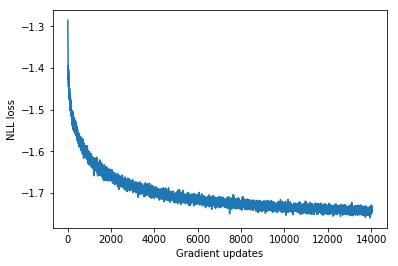

In [316]:
#plotting the negative log likelihood losses during training
import matplotlib.pyplot as plt
plt.plot(nll_train[50:])
plt.xlabel("Gradient updates")
plt.ylabel("NLL loss")

## Evaluations and Experiments

### Conditional Generations

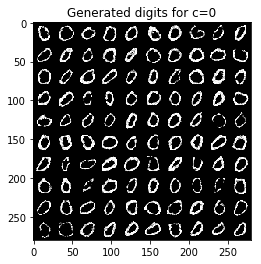

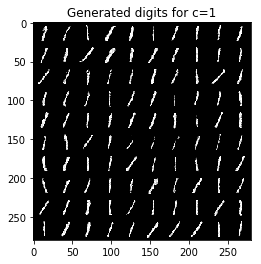

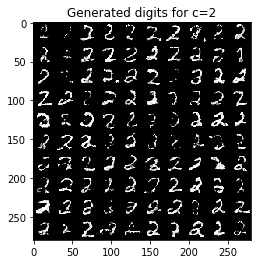

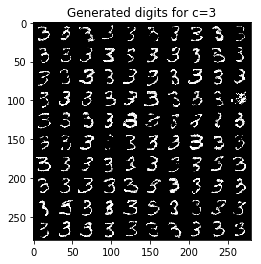

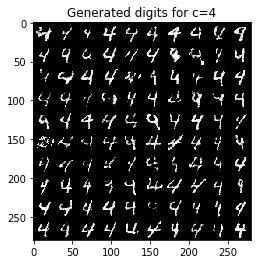

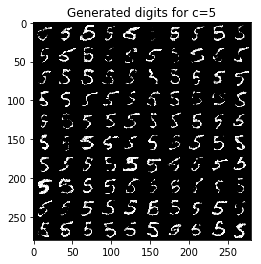

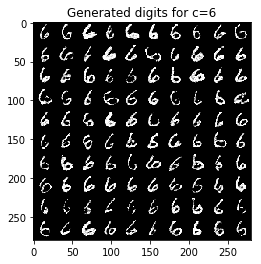

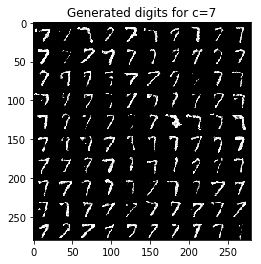

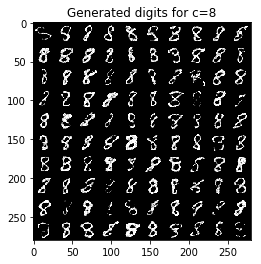

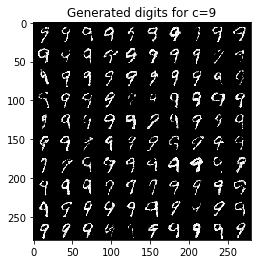

In [332]:
cinn.eval()
Z = []
#from 'https://github.com/VLL-HD/FrEIA/blob/master/experiments/mnist_minimal_example/eval.py'
def show_samples(label):
    '''produces and shows cINN samples for a given label (0-9)'''
    
    N_samples = 100    
    l = torch.LongTensor(N_samples)
    l[:] = label
    #varying 'z' for every sample 
    z = 1.0 * torch.randn(N_samples, 784) #randomly sampling latent vectors

    with torch.no_grad():
        samples = cinn.reverse_sample(z, l)
        #Z.append(z)  
    full_image = np.zeros((28*10, 28*10))

    for k in range(N_samples):
        i, j = k // 10, k % 10
        full_image[28 * i : 28 * (i + 1),
                   28 * j : 28 * (j + 1)] = samples[k, 0]

    full_image = np.clip(full_image, 0, 1)
    plt.figure()
    plt.title(F'Generated digits for c={label}')
    plt.imshow(full_image, vmin=0, vmax=1, cmap='gray')
    return(z)

for i in range(10):
    z = show_samples(i)
    Z.append(z) #storing 'z' to identify which feature of 'x' is controlled by them and for later use.
plt.show()



### Identification of latent vectors for various styles (slant, bold etc.)

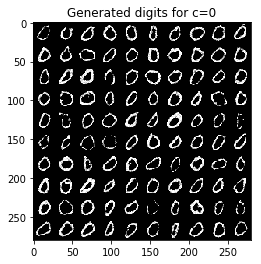

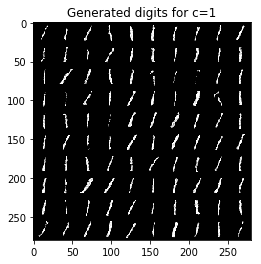

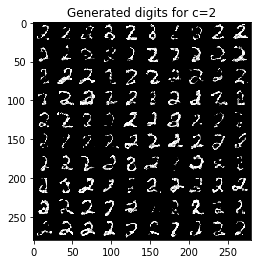

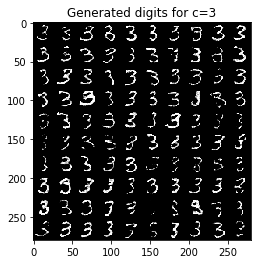

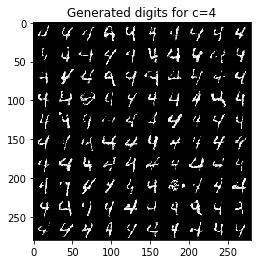

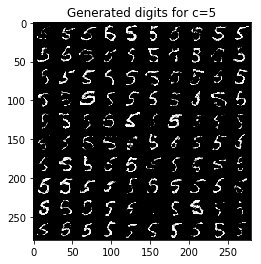

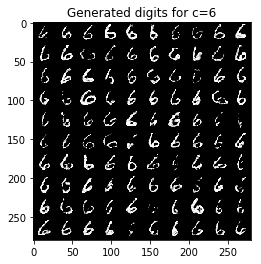

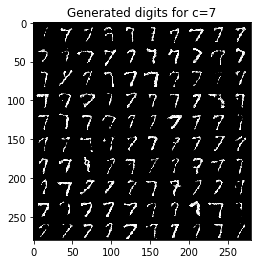

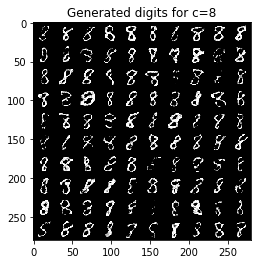

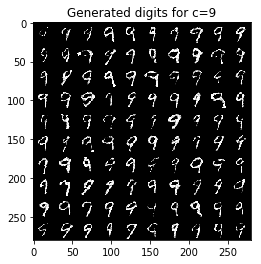

In [378]:
cinn.eval()
Z = []
#keeping 'z' fixed so that upon changing the condition (here, label) the style remains unchanged
z = 1.0 * torch.randn(100, 784) 
#from 'https://github.com/VLL-HD/FrEIA/blob/master/experiments/mnist_minimal_example/eval.py'
def show_samples(label):
    '''produces and shows cINN samples for a given label (0-9)'''
    
    N_samples = 100    
    l = torch.LongTensor(N_samples)
    l[:] = label

    #z = 1.0 * torch.randn(N_samples, 784) #randomly sampling latent vectors

    with torch.no_grad():
        samples = cinn.reverse_sample(z, l)
        #Z.append(z)  
    full_image = np.zeros((28*10, 28*10))

    for k in range(N_samples):
        i, j = k // 10, k % 10
        full_image[28 * i : 28 * (i + 1),
                   28 * j : 28 * (j + 1)] = samples[k, 0]

    full_image = np.clip(full_image, 0, 1)
    plt.figure()
    plt.title(F'Generated digits for c={label}')
    plt.imshow(full_image, vmin=0, vmax=1, cmap='gray')
    return(z)

for i in range(10):
    z = show_samples(i)
    Z.append(z) #storing 'z' to identify which feature of 'x' is controlled by them and for later use.
plt.show()



In [379]:
z

tensor([[-1.3514, -1.8505,  0.3607,  ...,  1.2388, -0.9633,  1.3158],
        [-0.3769, -1.1240,  0.1994,  ...,  1.1815,  0.0065, -0.0763],
        [ 0.7466, -1.7236, -1.6686,  ..., -0.3252,  1.6502,  0.2913],
        ...,
        [-1.1285,  0.7178, -2.3609,  ..., -1.4431,  0.3597,  1.0347],
        [ 1.4050, -0.0402, -0.6327,  ...,  0.9984, -0.5838,  0.6682],
        [-0.3006, -0.4771, -2.9326,  ...,  0.2914,  0.4092,  0.2771]])

### Style Transfer

In [382]:
test_im = []
Z_test = []
#Append all test images and their corresponding 'z' vector into one variable.
for i, (x, l) in enumerate(testloader):
    test_im.append(x)
    z, _ = cinn(x, l)
    Z_test.append(z)

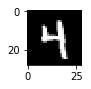

In [479]:
#Example of slightly left slant
im1 = test_im[1][39]
im1 = im1.reshape(28, 28)
plt.figure(figsize = (1, 1))
plt.imshow(im1, cmap = 'gray')


In [480]:
z = Z_test[1][39]

/export/home/sdubey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/export/home/sdubey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/export/home/sdubey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/export/home/sdubey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use 

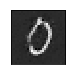

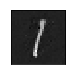

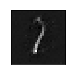

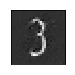

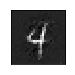

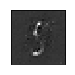

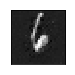

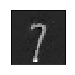

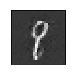

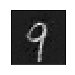

In [481]:
def show_samples1(label, z):
    '''produces and shows cINN samples for a given label (0-9)'''

    N_samples = 1
    l = torch.LongTensor(N_samples)
    l[:] = label

    z = torch.tensor(z).float()
    z = z.view(1, 784)
    
    with torch.no_grad():
        samples = cinn.reverse_sample(z, l)
    
    samples = samples.view(28, 28)
    plt.figure(figsize = (1, 1))
    plt.imshow(samples.detach().numpy(), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    

for i in range(10):
    show_samples1(i, z/100000)
    #print(z)


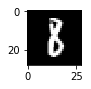

In [486]:
#Example of no slant
im1 = test_im[1][1]
im1 = im1.reshape(28, 28)
plt.figure(figsize = (1, 1))
plt.imshow(im1, cmap = 'gray')



/export/home/sdubey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/export/home/sdubey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/export/home/sdubey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/export/home/sdubey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use 

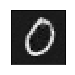

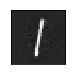

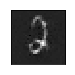

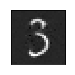

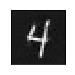

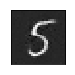

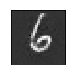

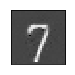

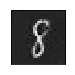

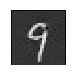

In [487]:
z = Z_test[1][1]

for i in range(10):
    show_samples1(i, z/100000)

### PCA on the latent vectors of test data

In [236]:
batch_size_pca = 10000
#As per the cINN paper, no noise augmentation should be performed.
trainset_pca, testset_pca, classes_pca = load_mnist(aug = False)
trainloader_pca, validloader_pca, testloader_pca = make_dataloaders(trainset, testset, batch_size = batch_size_pca)

tensor([32548, 14212, 12186,  ...,  8210, 28126, 23904])


In [237]:
X_test_pca = []
z_test_pca = []
y_test_pca = []
label_pca = []
for i, (x, l) in enumerate(testloader_pca):
    z_pca, log_j_pca = cinn(x, l)
    X_test_pca.append(x)
    z_test_pca.append(z_pca)
    y_pca = cinn.reverse_sample(z_pca, l)
    y_test_pca.append(y_pca)
    label_pca.append(l)

In [239]:
y_pca = cinn.reverse_sample(z_pca, l)
z = z_test_pca[0].detach().numpy()

In [245]:
#Normalize 'z' for PCA
z = (z-np.min(z))/(np.max(z)-np.min(z))

In [247]:
import pandas as pd
df_pca = pd.DataFrame(z,columns=feat_cols)
df_pca['label'] = label_pca[0] 
df_pca.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0.701219,0.701225,0.701017,0.701211,0.701360,0.701340,0.701262,0.700967,0.701396,0.701126,...,0.701976,0.701203,0.701432,0.701130,0.698789,0.701592,0.701668,0.701167,0.702207,7
1,0.700942,0.701676,0.700541,0.701340,0.701171,0.701330,0.701300,0.700968,0.701570,0.701069,...,0.702078,0.701277,0.701453,0.701192,0.700991,0.701360,0.701268,0.701099,0.701949,2
2,0.700532,0.699769,0.700969,0.701281,0.701098,0.700969,0.701444,0.700967,0.701923,0.700996,...,0.700908,0.701130,0.701419,0.701122,0.700329,0.701395,0.700639,0.701159,0.702202,1
3,0.701343,0.701912,0.701356,0.701177,0.701259,0.701630,0.701185,0.699789,0.701362,0.701207,...,0.702026,0.701280,0.700957,0.700925,0.696926,0.700924,0.701397,0.700985,0.702537,0
4,0.701258,0.702020,0.701351,0.701343,0.701437,0.701460,0.701265,0.700255,0.701460,0.700729,...,0.702520,0.700980,0.701407,0.699390,0.698918,0.702498,0.701505,0.701114,0.702697,4


In [248]:
pca_z = PCA(n_components=2)
principalComponents_z = pca_z.fit_transform(df_pca.iloc[:,:-1])

In [249]:
principal_z_Df = pd.DataFrame(data = principalComponents_z
             , columns = ['principal component 1', 'principal component 2'])
principal_z_Df['label'] = label_pca[0] 

In [250]:
principal_z_Df.head()

,principal component 1,principal component 2,label
0,-0.030559,-0.001916,7
1,-0.035524,0.002138,2
2,-0.031567,0.002228,1
3,-0.027190,-0.003192,0
4,-0.017100,0.000212,4


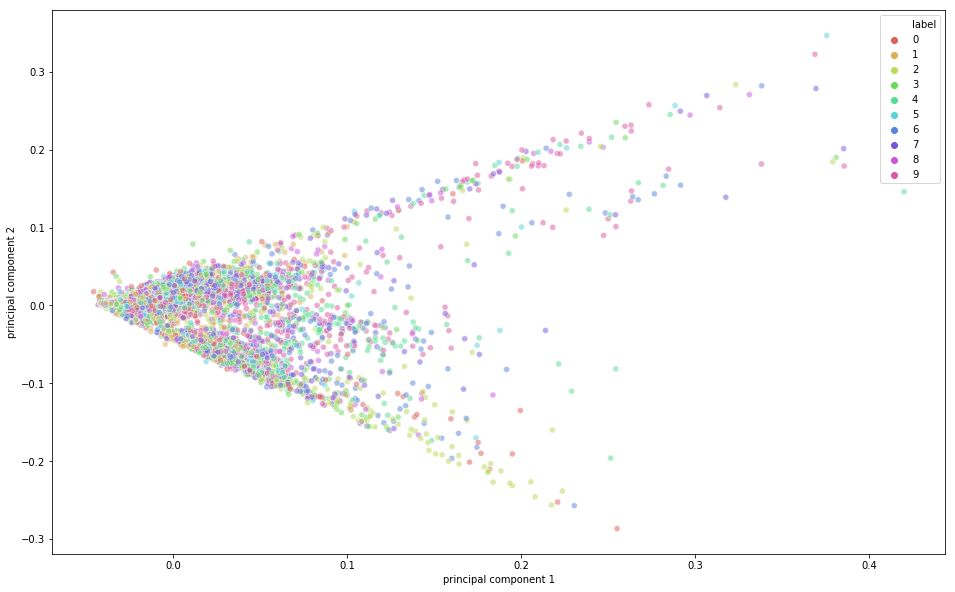

In [251]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=principal_z_Df,
    legend="full",
    alpha=0.5
)

In [507]:
principalComponents_z.shape


(10000, 2)

In [502]:
#manually identify meaningful directions in the subspace
#of the first four principal components.

#thickness
z1 = pca_z.inverse_transform([-0.05, 0])
z1_1 = pca_z.inverse_transform([0.1, 0.1])
#slant (no PCA, just randomly chosen 'z')
z2 = 1.0 * np.random.randn(1, 784)

In [305]:
#thickness (no PCA, just randomly chosen 'z')
z3 = 1.0 * np.random.rand(1, 784)

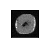

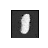

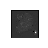

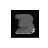

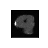

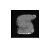

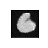

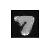

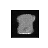

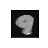

In [489]:
def show_samples(label, z):
    '''produces and shows cINN samples for a given label (0-9)'''

    N_samples = 1
    l = torch.LongTensor(N_samples)
    l[:] = label

    z = torch.tensor(z).float()
    z = z.view(1, 784)
    
    with torch.no_grad():
        samples = cinn.reverse_sample(z, l)
    
    samples = samples.view(28, 28)
    plt.figure(figsize = (0.5, 0.5))
    plt.imshow(samples.detach().numpy(), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    

for i in range(10):
    show_samples(i, z1)

#plt.show()

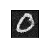

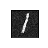

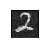

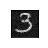

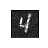

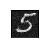

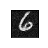

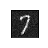

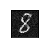

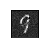

In [296]:
for i in range(10):
    show_samples(i, z2)

#plt.show()

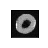

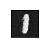

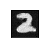

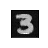

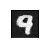

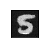

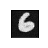

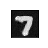

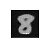

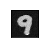

In [304]:
for i in range(10):
    show_samples(i, z3)

## Visualizations

In [218]:
X_test = []
z_test = []
y_test = []
for i, (x, l) in enumerate(testloader):
    z, log_j = cinn(x, l)
    X_test.append(x)
    z_test.append(z)
    y = cinn.reverse_sample(z, l)
    y_test.append(y)

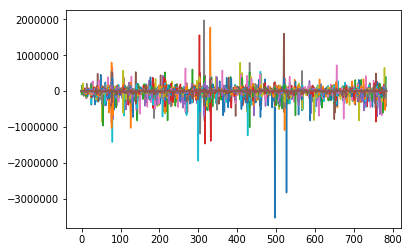

In [515]:
#This is a very vague attempt at plotting p(z|x) for a batch (size = 256) of z vextors generated from input images. 
#As INNs ensure that every input image generates a unique 'z', hence no discriminator (as in GANs) is essential
z = z_test[0].view(784, 256)
plt.plot(z.detach().numpy())


In [514]:
z_test[0].shape

torch.Size([256, 784])

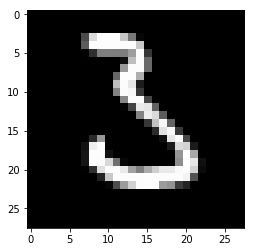

In [308]:
x_im = X_test[10][0].detach().numpy()
x_im = x_im.reshape(28, 28)
plt.imshow(x_im, cmap = 'gray')

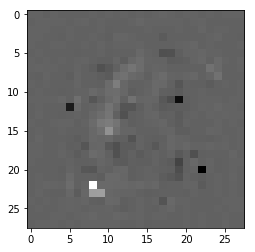

In [309]:
#The reconstructions do not seem very appealing due to noise augmented data utilized for training, however without noise augmentation
#the reconstructions look better and are illustrated in the other Jupyter notebook
y_im = y_test[10][0].detach().numpy()
#print(y_im.shape)
y_im = y_im.reshape(28, 28)
plt.imshow(y_im, cmap = 'gray')

Text(0, 0.5, '(x-y)')

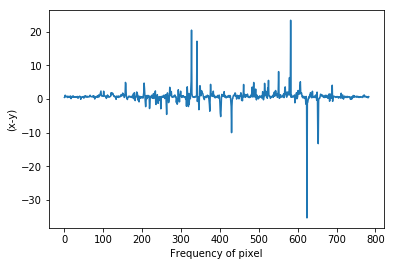

In [508]:
#y_im = y_test[10][0].detach().numpy()
#x = X_test[10][0].detach().numpy()
x = np.reshape(x_im, (784))
y = np.reshape(y_im, (784))
#plt.plot(x)
#plt.plot(y)
plt.plot(x-y)
plt.xlabel('Frequency of pixel')
plt.ylabel('(x-y)')

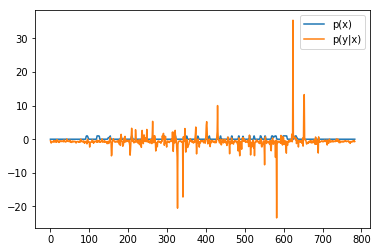

In [510]:
#plotting the prior distribution of image and distribution of reconstructed image conditioned on original image.
plt.plot(x, label = 'p(x)')
plt.plot(y, label = 'p(y|x)')
plt.legend()

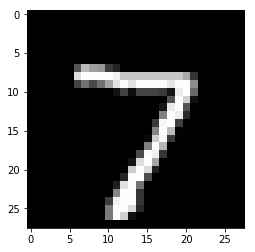

In [46]:
x_im = X_test[0][0].detach().numpy()
x_im = x_im.reshape(28, 28)
plt.imshow(x_im, cmap = 'gray')

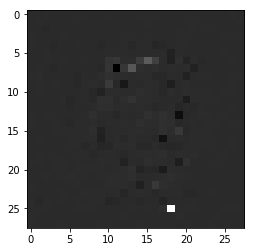

In [77]:
y_im = y_test[15][10].detach().numpy()
#print(y_im.shape)
y_im = y_im.reshape(28, 28)
plt.imshow(y_im, cmap = 'gray')